# Initial analysis of OPS-SAT with Betsi

This is an initial analysis of OPS-SAT telemetry with Betsi, based on [Red's work analyzing BOBCAT-1 telemetry](https://gitlab.com/librespacefoundation/polaris/polaris-playground/-/blob/master/notebooks/betsi/Betsi%20Analysis%20-%20BOBCAT-1.ipynb).  (And by "based on", I mean "straight-up copy-pasta".)  It was originally done to get useful supporting information for [our proposal to run an experiment on OPS-SAT](https://gitlab.com/librespacefoundation/polaris/polaris/-/milestones/7).

There are a few shortcomings with the analysis done here:

- The date range was selected pretty much at random due to earlier problems analyzing the full range.
- The training run was shortened considerably in order to get results more quickly.
- The dates displayed in the figure are in odd order (December 19, then 25, then 24, then 23, then...); I haven't dug into this.
- The data was prepared using [a custom branch](https://gitlab.com/saintaardvark/polaris/-/tree/issue-169-handle-exceptions-fetching-spaceweather) of Polaris that dealt with [this bug](https://gitlab.com/librespacefoundation/polaris/polaris/-/issues/169) (which, as I write, is about to be addressed by [@deckbsd's merge request](https://gitlab.com/librespacefoundation/polaris/polaris/-/merge_requests/191)).

Further info will be given all all these points as we go on.

First, let's start with the usual imports and set a good figure size.

In [1]:
# workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='DEBUG'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from polaris.anomaly import detector

from betsi import models, preprocessors, predictors
import json
from sklearn.model_selection import train_test_split
from polaris.data.readers import read_polaris_data

In [2]:
# Plot configurations
plt.rcParams["figure.figsize"] = (25,8)

# Fetching/Loading Data with Polaris tools

The data for OPS-SAT was fetched using [this personal repo](https://gitlab.com/saintaardvark/opssat-analysis).  Details are in there, but here's a brief outline.

All the frames held by db.satnogs.org were downloaded in CSV format using the "Export all frames" button at https://db.satnogs.org/satellite/44878/.  (Note that you need to create an account there in order to see this option.)  For simplicity, that CSV file was mirrored on my personal website.

Using the Makefile in [my repo](https://gitlab.com/saintaardvark/opssat-analysis), I ran `make short`. This command:

- downloaded the mirror of the CSV file from my personal website;
- took the first 3000 lines and saved it to a separate file;
- ran `polaris fetch --import` on that file, which created a Polaris Dataset file named `opssat1-normalized_frames-short.json`.

It's that last file -- `opssat1-normalized_frames-short.json` -- that we'll be analyzing here.

In [4]:
!ls -l ../opssat-analysis/opssat1-normalized_frames-short.json

-rw-r--r--. 1 aardvark aardvark 32305844 May 18 20:32 ../opssat-analysis/opssat1-normalized_frames-short.json


In [5]:
M = read_polaris_data("../opssat-analysis/opssat1-normalized_frames-long.json")

NameError: name 'read_polaris_data' is not defined

# Using Betsi

## Selecting numerical and variable dataset

### Using polaris metadata

In [7]:
type(M[0])

polaris.dataset.metadata.PolarisMetadata

In [8]:
type(M[1])

pandas.core.frame.DataFrame

In [10]:
# Selection per polaris metadata information
column_selection = [c for c in M[0]["analysis"]["column_tags"] 
                    if M[0]["analysis"]["column_tags"][c] == "variable" ]


In [11]:
# In Red's original notebook, he was combining two separate dataframes, and `all_selection` combined
# `column_selection` and another variable called `column_selection2`.  That's not the case here, but
# I haven't yet had time to rewrite this.

all_selection = column_selection

### Concatenating data and removing all remaining non numerical columns

In [13]:
data = pd.concat([M[1][all_selection]])

In [14]:
# Overal check of all present variables types
all_types = [data[col].dtype for col in data.columns]
print("{} columns in M with types from (dtype('O') is Object):".format(len(all_types)))
print(np.unique(np.sort(all_types)))


55 columns in M with types from (dtype('O') is Object):
[dtype('float64') dtype('O')]


In [15]:
data.shape

(706583, 55)

In [17]:
all_numerical_cols = [col for col in all_selection 
                      if data[col].dtype  == "float64" or data[col].dtype == "int64"]
print(all_numerical_cols)

['pid', 'board_temperature', 'pa_temperature', 'last_received_rssi', 'last_received_rf_error', 'number_of_tx_packets_since_reboot', 'number_of_rx_packets_since_reboot', 'number_of_tx_bytes_since_reboot', 'number_of_rx_bytes_since_reboot', 'active_system_configuration', 'reboot_number', 'reboot_cause', 'last_valid_packet_timestamp', 'background_rssi_level', 'tx_duty_time_since_reboot', 'total_tx_packets', 'total_rx_packets', 'total_tx_bytes', 'total_rx_bytes', 'Fredericksburg A', 'College K 12-15', 'Fredericksburg K 0-3', 'Planetary K 9-12', 'Fredericksburg K 15-18', 'Planetary K 6-9', 'College K 18-21', 'College K 3-6', 'Planetary K 21-24', 'Planetary K 3-6', 'College K 0-3', 'Fredericksburg K 18-21', 'Planetary K 12-15', 'College K 9-12', 'Planetary K 18-21', 'College K 21-24', 'College K 15-18', 'Fredericksburg K 21-24', 'College K 6-9', 'Fredericksburg K 9-12', 'Fredericksburg K 12-15', 'Planetary K 15-18', 'College A', 'Fredericksburg K 6-9', 'Fredericksburg K 3-6', 'Electron 800 K

In [18]:
# Final data column selection

data = data[all_numerical_cols]
print(data.shape)
data.head()

(706583, 53)


pid  board_temperature  pa_temperature  last_received_rssi  \
0  240.0              475.0           479.0               -87.0   
1  240.0              475.0           478.0               -87.0   
2  240.0              475.0           478.0               -87.0   
3  240.0              475.0           478.0               -87.0   
4  240.0              475.0           479.0               -87.0   

   last_received_rf_error  number_of_tx_packets_since_reboot  \
0                   321.0                             4380.0   
1                   321.0                             4379.0   
2                   321.0                             4378.0   
3                   321.0                             4377.0   
4                   321.0                             4375.0   

   number_of_rx_packets_since_reboot  number_of_tx_bytes_since_reboot  \
0                                4.0                         739120.0   
1                                4.0                         739026.0   
2                                4.0                         738932.0   
3                                4.0                         738838.0   
4                                4.0                         738650.0   

   number_of_rx_bytes_since_reboot  active_system_configuration  ...  \
0                             84.0                          2.0  ...   
1                             84.0                          2.0  ...   
2                             84.0                          2.0  ...   
3                             84.0                          2.0  ...   
4                             84.0                          2.0  ...   

   Fredericksburg K 3-6  Electron 800 KeV  Electron 2 MeV  Proton 100 MeV  \
0                   1.0       100000000.0       1000000.0          3700.0   
1                   1.0       100000000.0       1000000.0          3700.0   
2                   1.0       100000000.0       1000000.0          3700.0   
3                   1.0       100000000.0       1000000.0          3700.0   
4                   1.0       100000000.0       1000000.0          3700.0   

   Proton 1 MeV  Proton 10 MeV  Sunspot Area    Radio Flux  \
0     1300000.0        22000.0           0.0  7.000000e-21   
1     1300000.0        22000.0           0.0  7.000000e-21   
2     1300000.0        22000.0           0.0  7.000000e-21   
3     1300000.0        22000.0           0.0  7.000000e-21   
4     1300000.0        22000.0           0.0  7.000000e-21   

   X-ray Background Flux          time  
0           8.300000e-08  1.619375e+09  
1           8.300000e-08  1.619375e+09  
2           8.300000e-08  1.619374e+09  
3           8.300000e-08  1.619374e+09  
4           8.300000e-08  1.619374e+09  

[5 rows x 53 columns]

## Data preparation for the betsi auto-encoder based method

### Saving time index

In [19]:
# Keeping time index for later usage
time_index = pd.to_datetime(data.time, unit="s")
print(time_index.describe())

# Because data was built from 2 different dataframes.
time_index.index = range(time_index.shape[0])

count                  706583
unique                 272759
top       2020-12-01 18:08:23
freq                       46
first     2019-12-18 11:08:17
last      2021-04-25 18:15:19
Name: time, dtype: object


### Normalizing data for neural network input

In [20]:
print(data.isna().sum())
print("\n\t Although we have NaN we will imput them on the normalized data")

pid                                      77
board_temperature                    587710
pa_temperature                       587710
last_received_rssi                   587710
last_received_rf_error               587710
number_of_tx_packets_since_reboot    587710
number_of_rx_packets_since_reboot    587710
number_of_tx_bytes_since_reboot      587710
number_of_rx_bytes_since_reboot      587710
active_system_configuration          587710
reboot_number                        587710
reboot_cause                         587710
last_valid_packet_timestamp          587710
background_rssi_level                587710
tx_duty_time_since_reboot            587710
total_tx_packets                     587710
total_rx_packets                     587710
total_tx_bytes                       587710
total_rx_bytes                       587710
Fredericksburg A                          0
College K 12-15                           0
Fredericksburg K 0-3                      0
Planetary K 9-12                

In [21]:
# Step 1: Normalize the data
ndata, normalizer = preprocessors.normalize_all_data(data)

ndata = ndata.apply(lambda col: col.fillna(col.mean()),axis=0)

In [22]:
# Step 2: Convert it to columns using fixed stride and window size using Betsi preprocessor
window_size = 10
stride = 5
converted_data = preprocessors.convert_to_column(ndata, window_size=window_size, stride=stride)
print(converted_data.shape)

(141316, 530)


In [23]:
# This should be zero here
converted_data.isna().sum().sum()

0

In [24]:
print("The input data {} has {} features all included and {} observations".format(ndata.shape, ndata.shape[1], ndata.shape[0]))
print("Window size is {}\nand stride is {}\n\t ==> thus generating a matrix for neural network input of size {}".format(window_size, stride, converted_data.shape))
print("\n\tFor info {}(observations)/{}(stride) = {}".format(ndata.shape[0], stride, ndata.shape[0]/stride))

The input data (706583, 53) has 53 features all included and 706583 observations
Window size is 10
and stride is 5
	 ==> thus generating a matrix for neural network input of size (141316, 530)

	For info 706583(observations)/5(stride) = 141316.6


## Neural Network settings

In [25]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = "MSE"
layer_dims = [ converted_data.shape[1], 100, 30]
print(layer_dims)

[530, 100, 30]


In [26]:
# by Default layer activiations are ReLu
ae_model, en_model, de_model = models.custom_autoencoder(layer_dims) #, activations=activations)
# Compile the model for training
ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
en_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
de_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Fit and evaluate model

**Note:** Red's notebook originally trained for 1000 epochs.  As I was in a hurry, I went with just 50 in order to get quicker results.  As a result, the final model may not be as accurate as it could be.

In [27]:
train_data, test_data = train_test_split(
        converted_data,
        test_size=0.10, # usually 33% of data is for testing, 
        shuffle=False, # We disable shuffling since order matters (time)
    )

# You can also play around with the batch_size and epochs and enable
# early_stopping based on your needs
history = ae_model.fit(train_data, train_data, batch_size=32, epochs=1000)

# To test the model to check if it has overfit, you can run:
ae_model.evaluate(test_data, test_data, batch_size=32)

Epoch 1/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.4076 - MSE: 0.4006
Epoch 2/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3722 - MSE: 0.3683
Epoch 3/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3721 - MSE: 0.3691
Epoch 4/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3630 - MSE: 0.3605
Epoch 5/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3630 - MSE: 0.3607
Epoch 6/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3560 - MSE: 0.3539
Epoch 7/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3624 - MSE: 0.3603
Epoch 8/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3616 - MSE: 0.3597
Epoch 9/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3617 - MSE: 0.3598
Epoch 10/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3507 - MSE: 0.3489
Epoch 11/

3975/3975 [==============================] - 5s 1ms/step - loss: 0.3401 - MSE: 0.3387
Epoch 84/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3436 - MSE: 0.3423
Epoch 85/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3444 - MSE: 0.3431
Epoch 86/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3396 - MSE: 0.3383
Epoch 87/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3347 - MSE: 0.3334
Epoch 88/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3366 - MSE: 0.3353
Epoch 89/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3402 - MSE: 0.3388
Epoch 90/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3392 - MSE: 0.3379
Epoch 91/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3546 - MSE: 0.3534
Epoch 92/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3287 - MSE: 0.3274
Epoch 93/1000


3975/3975 [==============================] - 5s 1ms/step - loss: 0.3226 - MSE: 0.3212
Epoch 246/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3156 - MSE: 0.3141
Epoch 247/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3268 - MSE: 0.3254
Epoch 248/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3225 - MSE: 0.3211
Epoch 249/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3227 - MSE: 0.3212
Epoch 250/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3193 - MSE: 0.3179
Epoch 251/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3129 - MSE: 0.3114
Epoch 252/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3037 - MSE: 0.3022
Epoch 253/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3199 - MSE: 0.3184
Epoch 254/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3150 - MSE: 0.3135
Epoch

3975/3975 [==============================] - 5s 1ms/step - loss: 0.2992 - MSE: 0.2977
Epoch 408/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3018 - MSE: 0.3003
Epoch 409/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3088 - MSE: 0.3073
Epoch 410/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3054 - MSE: 0.3039
Epoch 411/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3147 - MSE: 0.3132
Epoch 412/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3206 - MSE: 0.3192
Epoch 413/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3062 - MSE: 0.3048
Epoch 414/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3080 - MSE: 0.3066
Epoch 415/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3001 - MSE: 0.2987
Epoch 416/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3050 - MSE: 0.3036
Epoch

3975/3975 [==============================] - 5s 1ms/step - loss: 0.2931 - MSE: 0.2917
Epoch 570/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2937 - MSE: 0.2923
Epoch 571/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2988 - MSE: 0.2974
Epoch 572/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3006 - MSE: 0.2992
Epoch 573/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3112 - MSE: 0.3097
Epoch 574/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2999 - MSE: 0.2984
Epoch 575/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2941 - MSE: 0.2927
Epoch 576/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3120 - MSE: 0.3106
Epoch 577/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2939 - MSE: 0.2924
Epoch 578/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3126 - MSE: 0.3112
Epoch

3975/3975 [==============================] - 5s 1ms/step - loss: 0.2983 - MSE: 0.2967
Epoch 732/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3153 - MSE: 0.3138
Epoch 733/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3078 - MSE: 0.3063
Epoch 734/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3030 - MSE: 0.3015
Epoch 735/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2992 - MSE: 0.2977
Epoch 736/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3028 - MSE: 0.3012
Epoch 737/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3207 - MSE: 0.3192
Epoch 738/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2955 - MSE: 0.2940
Epoch 739/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2978 - MSE: 0.2963
Epoch 740/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3059 - MSE: 0.3043
Epoch

3975/3975 [==============================] - 5s 1ms/step - loss: 0.2972 - MSE: 0.2954
Epoch 894/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2978 - MSE: 0.2961
Epoch 895/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2995 - MSE: 0.2979
Epoch 896/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3020 - MSE: 0.3003
Epoch 897/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2928 - MSE: 0.2912
Epoch 898/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3187 - MSE: 0.3171
Epoch 899/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3107 - MSE: 0.3091
Epoch 900/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2948 - MSE: 0.2932
Epoch 901/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.3046 - MSE: 0.3030
Epoch 902/1000
3975/3975 [==============================] - 5s 1ms/step - loss: 0.2928 - MSE: 0.2912
Epoch

[0.7852072715759277, 0.7802906632423401]

In [29]:
ae_model.save('betsi-opssat')

INFO:tensorflow:Assets written to: betsi-opssat/assets


In [28]:
train_data.shape

(127184, 530)

## Running betsi analysis

### Predict and calculate feature-kernel distances 

In [30]:
# Step 1: Predict the "bottleneck" layer representation for the input data
data_rep = en_model.predict(converted_data)

# Step 2: Measure the distance between consecutive timestamps. This will be
# the metric to detect anomalies. Distance here refers to the L2 norm.
distance_list = []
for row_no in range(data_rep.shape[0] - 1):
    distance_list.append(
        predictors.distance_measure(data_rep[row_no], data_rep[row_no + 1]))

/home/aardvark/dev/src/polaris/.venv/lib/python3.8/site-packages/betsi/predictors.py:42: RuntimeWarning: divide by zero encountered in true_divide
  distance = norm_diff / math.sqrt(norm_array_1 * norm_array_2)
/home/aardvark/dev/src/polaris/.venv/lib/python3.8/site-packages/betsi/predictors.py:42: RuntimeWarning: invalid value encountered in true_divide
  distance = norm_diff / math.sqrt(norm_array_1 * norm_array_2)


In [46]:
data_rep

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 3.5914817, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.3709793, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.573153 , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

(141316, 30)


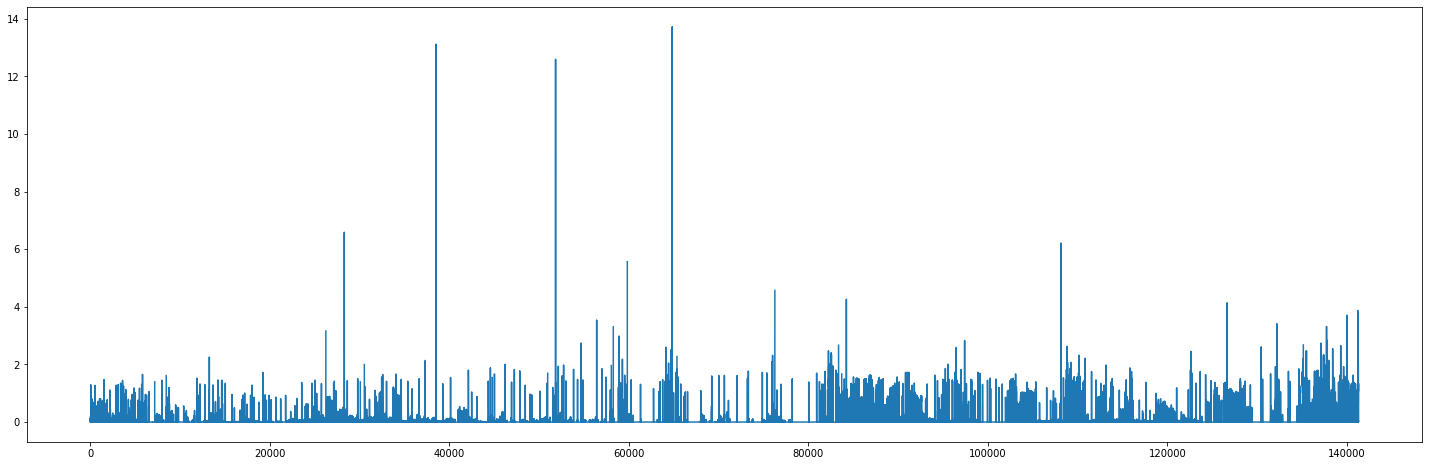

In [31]:
print(data_rep.shape)

plt.plot(distance_list)

In [32]:
# Step 3: Detect the events. We have a noise_margin_per variable to say
# how much (in percentage) should the value be above the average to be
# considered the event. Try playing around with this to find the best value!
noise_margin_per = 50 # 2.5 x the average ie 150% more than average
events = predictors.get_events(distance_list, threshold=noise_margin_per)

In [33]:
print("{} events detected with {}% average deviation".format(len(events), noise_margin_per))
print(events)

0 events detected with 50% average deviation
[]


### Plot events on the data

In [ ]:
#df_test = pd.read_pickle("/tmp/test_data.pkl")

# df_test = pd.read_pickle("/tmp/test_data.pkl")
# events = json.load(open("/tmp/anomaly_metrics.json"))["events"]

In [34]:
# events by order of breakage (difference with previous behavior) in DESC order (biggest first)
sorted_dist = np.argsort(distance_list)[::-1]
events_sorted = [evt for evt in sorted_dist if evt in events]

In [35]:
events_sorted

[]

In [36]:
print(distance_list[604])
print(distance_list[360])

0.002815123716750442
0.1357089393214802


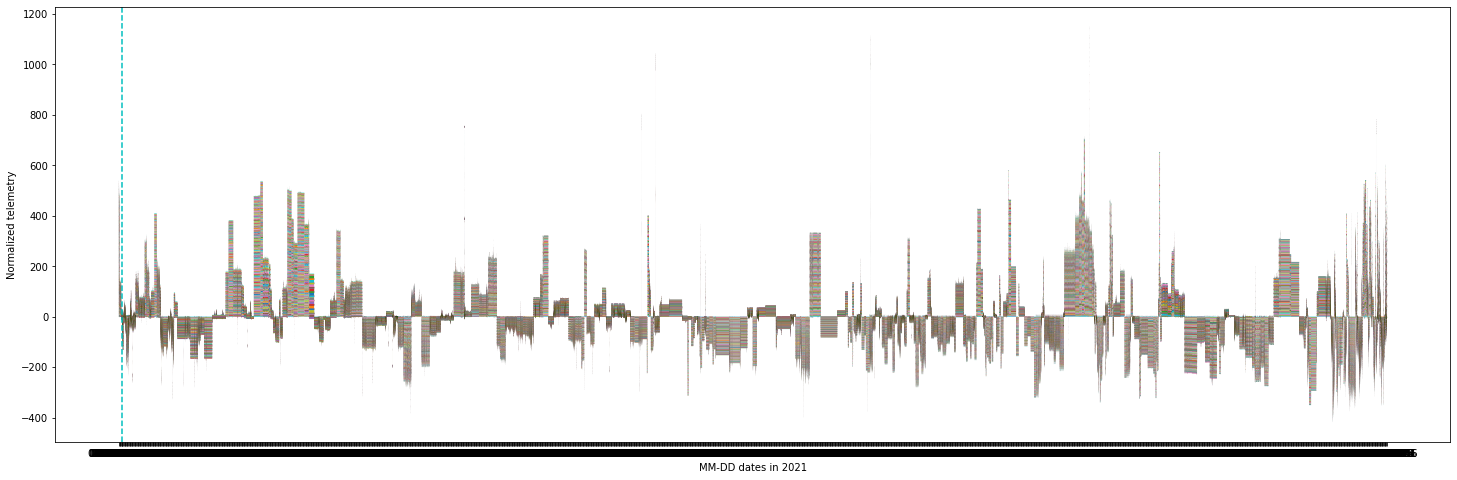

<Figure size 1800x576 with 0 Axes>

In [37]:
plt.close()

ndf = converted_data.to_numpy()

# Time index with one point every stride
ndf_time = (time_index.iloc[::stride]).iloc[:-1]

# To remove columns of data which are constant
#ndf[:, ~np.all(ndf[1:] == ndf[:-1], axis=0)]

# tot_cols = ndf.shape[1] # Not used
tot_rows = ndf.shape[0]

# Creating the stack plot
plt.stackplot(range(ndf.shape[0]), ndf.T)
#plt.stackplot(ndf_time.to_numpy().T, ndf.T)



# Plotting the events on top of the stackplots as dotted lines
for xc in events:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="k", linestyle="--")

# Plotting in red the 3 biggest changes
for xc in events_sorted[:5]:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="r", linestyle="--")

    
    


At = list(range(ndf.shape[0])[::80])
At_time_str = [str(d)[5:16] for d in ndf_time.to_numpy()[At]]

big_event_idx =  378
At.append(big_event_idx)
At_time_str.append(str(ndf_time.iloc[big_event_idx])[5:16] )
plt.xticks(At, At_time_str)
plt.axvline(big_event_idx, color="c", linestyle="--")

plt.xlabel("MM-DD dates in 2021")
plt.ylabel("Normalized telemetry")
plt.show()
plt.savefig("ttttt.png")

In [38]:
ndf.shape[0]

141316

In [39]:
str(ndf_time.iloc[378])

'2021-04-08 02:54:24'

In [40]:
378 in events

False

### Brownbag analysis

In [41]:
ndf_time.iloc[378]

Timestamp('2021-04-08 02:54:24')

In [42]:
ndf_time.iloc[360]

Timestamp('2021-04-08 15:58:15')

In [43]:
# Trying to see how much apart the betsi breakpoint (first datetime) is from information from operators (second datetime)
time_index[(time_index > '2021-04-24 15:38:14') & (time_index <= '2021-04-25 05:20:43')]

123   2021-04-24 16:48:28
124   2021-04-24 16:48:18
125   2021-04-24 16:48:18
126   2021-04-24 16:48:08
127   2021-04-24 16:47:58
128   2021-04-24 16:47:58
129   2021-04-24 16:47:48
130   2021-04-24 16:47:48
131   2021-04-24 16:47:38
132   2021-04-24 16:47:38
133   2021-04-24 16:47:28
134   2021-04-24 16:47:18
135   2021-04-24 16:47:08
Name: time, dtype: datetime64[ns]

In [44]:
def plot_events_against_real_telemetry(df, events_timestamps=None, savefig="/tmp/hhh.svg"):
    """ Tailored for a dataframe df that has a time column
    """
    plt.close()
    time_idx = pd.to_datetime(df.time, unit="s")
    # In case the time_idx has a wrong numbering
    time_idx.index = range(time_idx.shape[0])
    df.index = time_idx
    
    #plt.stackplot(range(df.shape[0]), df.T)
    normalized_df=(df-df.min())/(df.max()-df.min())
    #print(normalized_df.head())
    plt.plot(normalized_df, "ko", alpha=0.05)
    
    if events_timestamps is not None:
        for evt in events_timestamps:
            plt.axvline(evt, color="r", linestyle="--", linewidth="4", alpha=0.7)
            print(evt)
            
    plt.axvline('2021-04-25 05:20:43', color="c", linestyle="--", linewidth="4", alpha=0.9)
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized telemetry")
    
    plt.savefig(savefig)
    
    plt.show()
    print()

ConversionError: Failed to convert value(s) to axis units: '2021-04-25 05:20:43'

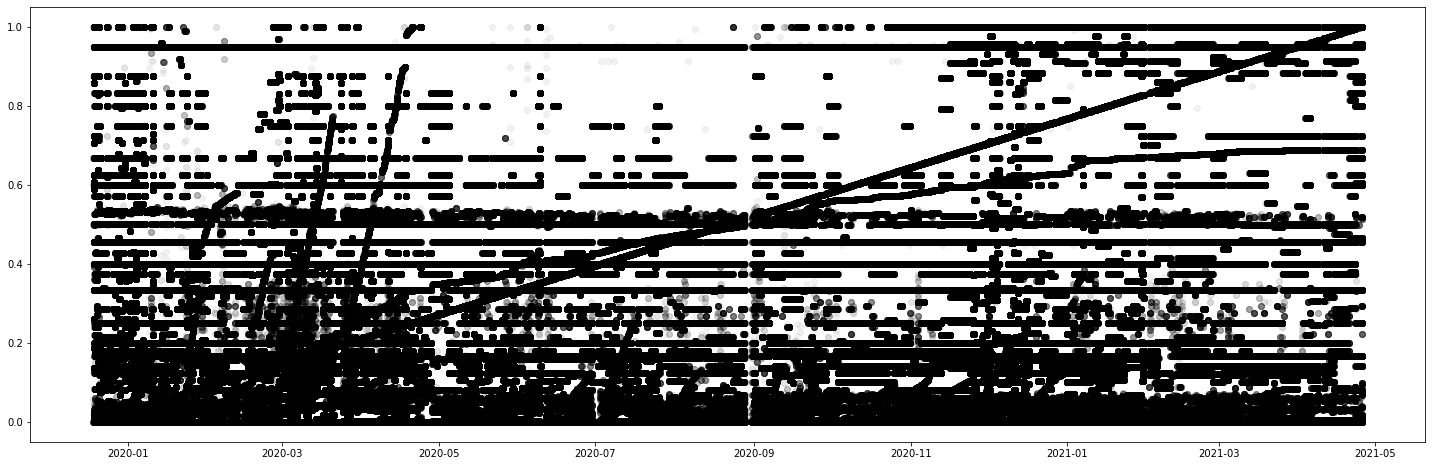

In [45]:
plot_events_against_real_telemetry(data, ndf_time.iloc[events])

In [150]:
# The window time of window_size
time_index[window_size] - time_index[0] 

Timedelta('0 days 00:55:00')

In [188]:
def extract_datasets_around_event(df, timeref, events_list, event_index=10, base_name="../data/bobcat-1-behavior-data"):
    D1 = df[(df.index > timeref.iloc[events_list[event_index-1]]) & (df.index <= timeref.iloc[events_list[event_index]])]
    D2 = df[(df.index > timeref.iloc[events_list[event_index]]) & (df.index <= timeref.iloc[events_list[event_index+1]])]
    print("Two datasets around {}".format(timeref.iloc[events_list[event_index]]))
    D1.to_csv(base_name+"-B1.csv")
    D2.to_csv(base_name+"-B2.csv")
    

In [184]:
ndf_time.iloc[events[9]]

Timestamp('2021-04-12 10:20:29')

In [187]:
extract_datasets_around_event(data, ndf_time, events, 10)

Two datasets around 2021-04-20 05:01:18


In [189]:
extract_datasets_around_event(data, ndf_time, events, 9, base_name="../data/bobcat-1-behavior-around-2021-04-12")

Two datasets around 2021-04-12 10:20:29


## Comparing graphs of two consecutive behavior periods

In [218]:
graph_before = "../data/bobcat-1-behavior-around-2021-04-12-BEFORE.json"
graph_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER.json"
graph_after_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER-AFTER.json"

In [216]:
def compare_two_graphs(gbefore, gafter):
    with open(gbefore, "r") as fff:
        json_before = json.load(fff)
    
    with open(gafter, "r") as fff:
        json_after = json.load(fff)
        
    for node in json_after["graph"]["nodes"]:
        if node not in json_before["graph"]["nodes"]:
            print("missing node from before: "+node)
                 
    for node in json_before["graph"]["nodes"]:
        if node not in json_after["graph"]["nodes"]:
            print("missing node from after: "+node)
            
    #uniqsrc = np.uniq([elt["source"] for elt in json_after["graph"]["links"]])
    
    def build_link_db(graph):
        db = {}
        for elt in graph["graph"]["links"]:
            if elt["source"] not in db:
                db[elt["source"]] = {}
            db[elt["source"]][elt["target"]] = elt["value"]
        return db
    
    after_db = build_link_db(json_after)
    before_db = build_link_db(json_before)
    for src in after_db:
        if src in before_db:
            for target in after_db[src]:
                if target in before_db[src]:
                    A = after_db[src][target]
                    B = before_db[src][target]
                    adiff = np.abs(A-B)
                    if adiff > 0.0:
                        if A > B:
                            A = B
                        if A/adiff > 0.2:
                            print("Consequent change on pair {} --> {} = from {} to {} ".format(
                                  src, target, before_db[src][target], after_db[src][target]))
                else:
                    print("New pair from already existing source {} --> {} = {} ".format(src, target, after_db[src][target]))
        else:
            print("No links were present before from that paramater:   "+src)
            for target in after_db[src]:
                print("\t--> "+target)

In [217]:
compare_two_graphs(graph_before, graph_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.23441638052463531 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.26385921239852905 
New pair from already existing source a3200_hktable_17_1_timestamp --> bootcount_a3200 = 0.5815030336380005 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.36011406779289246 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_count = from 0.19264103472232819 to 0.4315612018108368 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.45864996314048767 
New pair from already existing source a3200_hktable_17_1_timestamp --> deploy_attempts1 = 1.0

In [219]:
compare_two_graphs(graph_after, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
Consequent change on pair a3200_hktable_17_1_timestamp --> time.1 = from 0.23441638052463531 to 0.30380892753601074 
Consequent change on pair a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = from 0.26385921239852905 to 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
Consequent change on pair a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = from 0.36011406779289246 to 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.45864996314048767 to 0.16880464553833008 
Consequent change on pair a3200_hktable_17_1_timestamp --> timestamp = from 0.3080316185951233 to 0.23969678580760956 
No links were present before from that paramater:   bc1_wdcnt


In [220]:
compare_two_graphs(graph_before, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.30380892753601074 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.16880464553833008 
New pair from alr